# Домашнее задание к занятию «Улучшение качества обучения нейросети»

**Цель задания:** научиться использовать в коде различные методы Transfer Learning.

**Задание:**

На примере датасета персонажей мультфильма Симпсонов:

1. Модифицируйте код обучения, используя различные типы LR Schedulers из Pytorch. Проведите минимум 2 эксперимента с разными шедулерами.

2. Подберите аугментации train данных, при которых итоговое качество на валидации станет сильно хуже, чем полученное на занятии.

3. Возьмите любую архитектуру (VGG, EfficientNet или MobileNet) и примените к ней методы, которые разбирались на занятии.

4. Оформите вывод по результатам проведённых экспериментов.

In [1]:
import os
import time
import glob

from tqdm.notebook import tqdm
from collections import defaultdict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

import torch
from torch import nn
import torch.nn.functional as F
from torchsummary import summary

import torchvision
from torchvision import transforms
from torch.optim.lr_scheduler import ReduceLROnPlateau, MultiStepLR

from IPython.display import clear_output
%matplotlib inline

sns.set(font_scale=1.2)
sns.set_style(style='white')

In [2]:
from google.colab import files
files.upload()

!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d alexattia/the-simpsons-characters-dataset

Saving kaggle.json to kaggle.json
 99% 1.07G/1.08G [00:32<00:00, 25.7MB/s]
100% 1.08G/1.08G [00:32<00:00, 35.6MB/s]


In [3]:
import zipfile

zfile = zipfile.ZipFile(file='/content/the-simpsons-characters-dataset.zip')
zfile.extractall()

In [4]:
# Датасет продублирован внутри себя
!rm -rf /content/simpsons_dataset/simpsons_dataset

In [2]:
def correct_folder(name):
    contents = os.listdir(name)
    if len(contents) > 0:
        return True
    else:
        return False

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
INPUT_SIZE = 224
BATCH_SIZE = 64
NUM_EPOCHS = 10
lr = 0.01
print(device)

cuda


In [4]:
def show_images(dataset):
    fig, ax = plt.subplots(
        nrows=2, ncols=3, figsize=(8, 6),
        sharey=True, sharex=True
    )

    for fig_x in ax.flatten():
        idx = np.random.randint(low=0, high=6000)
        img, label = dataset[idx]
        fig_x.set_title(dataset.classes[label])
        fig_x.imshow(img.numpy().transpose((1, 2, 0)))

In [5]:
def plot_learning_curves(history):
    '''
    Функция для вывода графиков лосса и метрики во время обучения.
    '''
    fig = plt.figure(figsize=(20, 7))

    plt.subplot(1,2,1)
    plt.title('Лосс', fontsize=15)
    plt.plot(history['loss']['train'], label='train')
    plt.plot(history['loss']['val'], label='val')
    plt.ylabel('лосс', fontsize=15)
    plt.xlabel('эпоха', fontsize=15)
    plt.legend()

    plt.subplot(1,2,2)
    plt.title('Точность', fontsize=15)
    plt.plot(history['acc']['train'], label='train')
    plt.plot(history['acc']['val'], label='val')
    plt.ylabel('лосс', fontsize=15)
    plt.xlabel('эпоха', fontsize=15)
    plt.legend()
    plt.show()

In [6]:
def prepare_datasets(data_dir, train_augmentations=None, val_augmentations=None):
    """аугментация данных происходит в соотвествии с пайплайнами аугментации train_augmentations и val_augmentations"""
    data_paths = glob.glob(f"{data_dir}/*")
    data_image_paths = []
    data_image_labels = []
    for name in data_paths:
        if correct_folder(name):
            data_image_paths += glob.glob(f"{name}/*.jpg")
        else:
            print(name)
            os.rmdir(name)
    data_image_labels = [path.split('/')[-2] for path in data_image_paths]
    print(len(data_image_paths), len(data_image_labels))
    train_files_path, val_files_path = train_test_split(
        data_image_paths,
        test_size=0.3,
        stratify=data_image_labels
    )

    print(f"Изображений в train: {len(train_files_path)}\nИзображений в val: {len(val_files_path)}")
    input_size = 224
    if train_augmentations is not None:
        train_transform = transforms.Compose(train_augmentations)
    else:
        train_transform = transforms.Compose([
            transforms.Resize(input_size),
            transforms.CenterCrop(input_size),
            transforms.ToTensor(),
        ])
    if val_augmentations is not None:
        val_transform = transforms.Compose(val_augmentations)
    else:
        val_transform = transforms.Compose([
            transforms.Resize(input_size),
            transforms.CenterCrop(input_size),
            transforms.ToTensor(),
        ])

    train_dataset = torchvision.datasets.ImageFolder(
          data_dir,
          transform=train_transform,
          is_valid_file=lambda x: x in train_files_path
      )

    val_dataset = torchvision.datasets.ImageFolder(
          data_dir,
          transform=val_transform,
          is_valid_file=lambda x: x in val_files_path
      )
    return train_dataset, val_dataset

In [7]:
def train(
    model,
    criterion,
    optimizer,
    train_batch_gen,
    val_batch_gen,
    num_epochs=10,
    schedulers=None, names=None
):
    '''
    Функция для обучения модели и вывода лосса и метрики во время обучения.
    '''
    times = []
    l_rates = []
    history = defaultdict(lambda: defaultdict(list))

    for epoch in range(num_epochs):
        train_loss = 0
        train_acc = 0
        val_loss = 0
        val_acc = 0

        start_time = time.time()

        # устанавливаем поведение dropout / batch_norm  в обучение
        model.train(True)

        # на каждой "эпохе" делаем полный проход по данным
        for X_batch, y_batch in tqdm(train_batch_gen):
            # обучаемся на текущем батче
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            logits = model(X_batch)

            loss = criterion(logits, y_batch.long().to(device))

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            train_loss += np.sum(loss.detach().cpu().numpy())
            y_pred = logits.max(1)[1].detach().cpu().numpy()
            train_acc += np.mean(y_batch.cpu().numpy() == y_pred)

        # подсчитываем лоссы и сохраням в "историю"
        train_loss /= len(train_batch_gen)
        train_acc /= len(train_batch_gen)
        history['loss']['train'].append(train_loss)
        history['acc']['train'].append(train_acc)

        # устанавливаем поведение dropout / batch_norm в режим тестирования
        model.train(False)

        # полностью проходим по валидационному датасету
        for X_batch, y_batch in tqdm(val_batch_gen):
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            logits = model(X_batch)
            loss = criterion(logits, y_batch.long().to(device))
            val_loss += np.sum(loss.detach().cpu().numpy())
            y_pred = logits.max(1)[1].detach().cpu().numpy()
            val_acc += np.mean(y_batch.cpu().numpy() == y_pred)

        # подсчитываем лоссы и сохраням в "историю"
        val_loss /= len(val_batch_gen)
        val_acc /= len(val_batch_gen)
        history['loss']['val'].append(val_loss)
        history['acc']['val'].append(val_acc)

        clear_output()
        epoch_time = time.time() - start_time
        # печатаем результаты после каждой эпохи
        print("Epoch {} of {} took {:.3f}s".format(
            epoch + 1, num_epochs, epoch_time))
        times.append(epoch_time)
        print("  training loss (in-iteration): \t{:.6f}".format(train_loss))
        print("  validation loss (in-iteration): \t{:.6f}".format(val_loss))
        print("  training accuracy: \t\t\t{:.2f} %".format(train_acc * 100))
        print("  validation accuracy: \t\t\t{:.2f} %".format(val_acc * 100))

        plot_learning_curves(history)

        # подключаем шедулер
        if schedulers is not None:
            for scheduler, name in zip(schedulers, names):
                if name == 'ReduceLROnPlateau':
                    scheduler.step(val_loss)
                else:
                    scheduler.step()
                    l_rates.append(scheduler.get_last_lr())
        else:
            l_rates.append(lr)
    return model, history, times, l_rates

In [8]:
def fine_tuning(schedulers, name):
    fine_tuning_model = nn.Sequential()

    fine_tuning_model.add_module('mobilenet_v3', torchvision.models.mobilenet_v3_large(pretrained=True))

    fine_tuning_model.add_module('relu_1', nn.ReLU())
    fine_tuning_model.add_module('fc_1', nn.Linear(1000, 512))
    fine_tuning_model.add_module('relu_2', nn.ReLU())
    fine_tuning_model.add_module('fc_2', nn.Linear(512, 42))

    fine_tuning_model = fine_tuning_model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(fine_tuning_model.parameters(), lr=lr)

    clf_model, history, times = train(
      fine_tuning_model, criterion, optimizer,
      train_batch_gen, val_batch_gen,
      NUM_EPOCHS, schedulers, name
    )
    return clf_model, history, times

In [9]:
train_augmentations  = []
val_augmentations = []


train_augmentations = [
      transforms.Resize(INPUT_SIZE),
      transforms.CenterCrop(INPUT_SIZE),
      transforms.ColorJitter(0.9, 0.9, 0.9),
      transforms.RandomAffine(5),
      transforms.ToTensor(),
  ]

train_augmentations_bad = [
      transforms.Resize(INPUT_SIZE),
      transforms.CenterCrop(INPUT_SIZE),
      transforms.RandomVerticalFlip(p=0.5),
      transforms.ColorJitter(0.9, 0.9, 0.9),
      transforms.RandomAffine(5),
      transforms.ElasticTransform(alpha=250.0),
      transforms.ToTensor(),
  ]
train_augmentations.append(('Base', train_augmentations))
train_augmentations.append(('Bad', train_augmentations_bad))


val_augmentations = [
      transforms.Resize(INPUT_SIZE),
      transforms.CenterCrop(INPUT_SIZE),
      transforms.ToTensor(),
  ]

val_augmentations_bad = [
      transforms.Resize(INPUT_SIZE),
      transforms.CenterCrop(INPUT_SIZE),
      transforms.ToTensor(),
  ]
val_augmentations.append(('Base', val_augmentations))
val_augmentations.append(('Bad', val_augmentations_bad))

### Загрузим датасет
На занятии мы познакомимся с датасетом Симпсонов! Там собраны знакомые многим персонажи знаменитого мультфильма для решения задачи классификации.

In [13]:
data_dir = "/content/simpsons_dataset"
data_image_paths = glob.glob(f"{data_dir}/*")

In [11]:
train_dataset, val_dataset = prepare_datasets(data_dir)

20933 20933
Изображений в train: 14653
Изображений в val: 6280


In [12]:
train_batch_gen = torch.utils.data.DataLoader(
    train_dataset, batch_size=BATCH_SIZE, shuffle=True
)

val_batch_gen = torch.utils.data.DataLoader(
    val_dataset, batch_size=BATCH_SIZE, shuffle=False
)

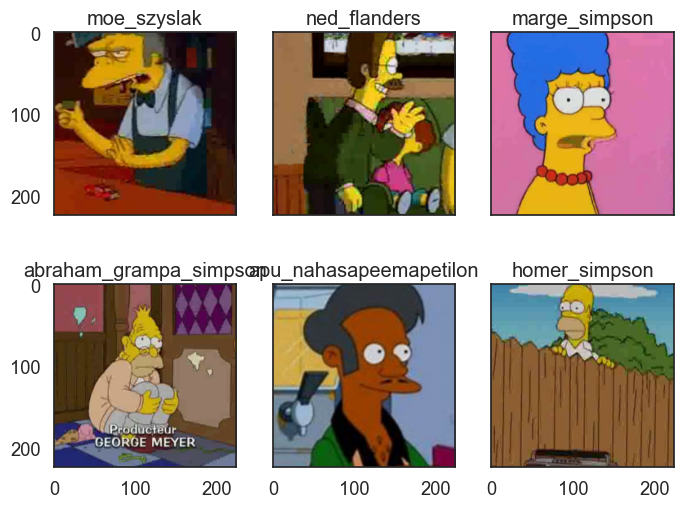

In [13]:
show_images(val_dataset)

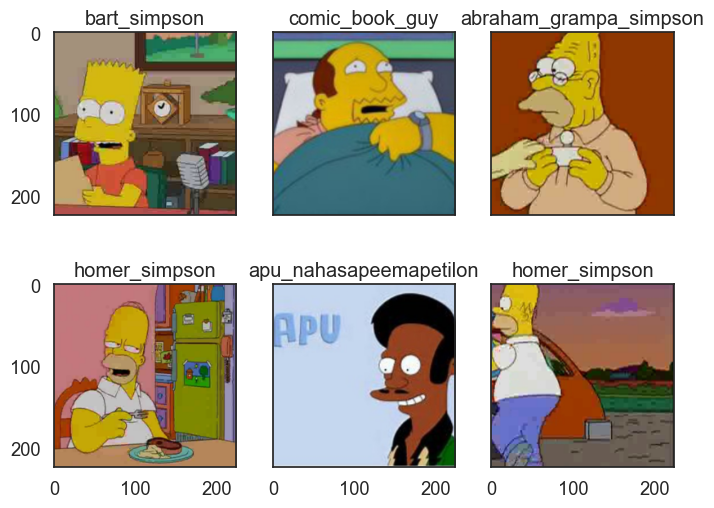

In [14]:
show_images(train_dataset)

In [15]:
results = dict()

In [ ]:
model = torchvision.models.mobilenet_v3_large(pretrained=False)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [ ]:
model.classifier = torch.nn.Sequential(
                    torch.nn.Linear(in_features=960, out_features=1280, bias=True),
                    torch.nn.Hardswish(),
                    torch.nn.Dropout(p=0.2, inplace=True),
                    torch.nn.Linear(in_features=1280, out_features=42, bias=True)
                    )

Epoch 10 of 10 took 132.806s
  training loss (in-iteration): 	0.926261
  validation loss (in-iteration): 	1.328072
  training accuracy: 			76.35 %
  validation accuracy: 			66.11 %


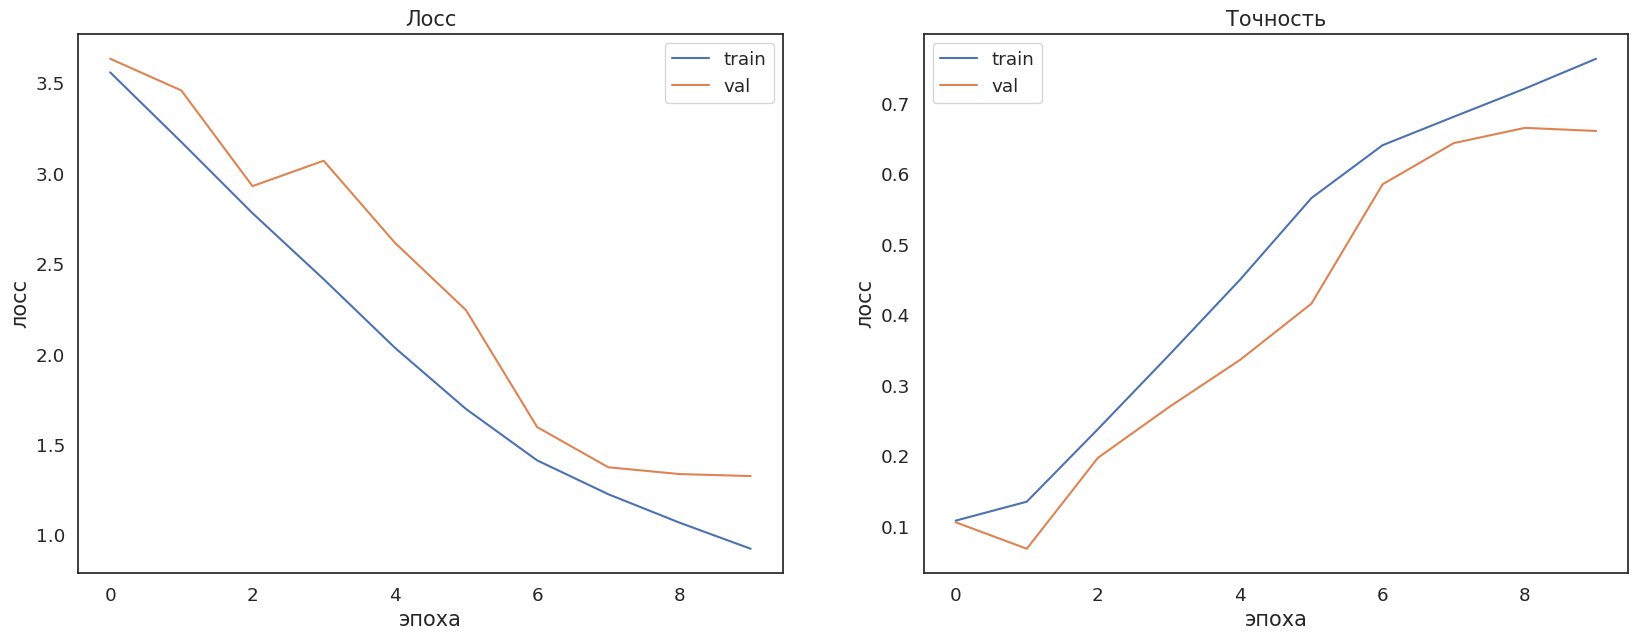

In [ ]:
criterion = nn.CrossEntropyLoss()
model = model.to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
clf_model, history,  times, l_rates = train(
      model, criterion, optimizer,
      train_batch_gen, val_batch_gen,
      NUM_EPOCHS, None
  )

In [ ]:
results['None'] = history

In [ ]:
df_results = pd.DataFrame(columns=['model','augmentation', 'sheduler','time', 'lr', 'epoch', 'train_loss', 'train_accuracy', 'val_loss', 'val_accuracy'])

In [ ]:
for i in range(10):
    df_results.loc[len(df_results.index)] = ['с нуля','Base', 'None', times[i], l_rates[i], i, results['None']['loss']['train'][i], results['None']['acc']['train'][i], results['None']['loss']['val'][i], results['None']['acc']['val'][i]]

In [ ]:
df_results

,model,augmentation,sheduler,time,lr,epoch,train_loss,train_accuracy,val_loss,val_accuracy
0,с нуля,Base,None,145.342730,0.01,0,3.560152,0.108645,3.635337,0.106376
1,с нуля,Base,None,135.033336,0.01,1,3.175031,0.135548,3.460162,0.068813
2,с нуля,Base,None,138.215456,0.01,2,2.781609,0.238451,2.931018,0.197759
3,с нуля,Base,None,132.925652,0.01,3,2.416715,0.343489,3.071519,0.269729
4,с нуля,Base,None,136.291000,0.01,4,2.037946,0.450633,2.618468,0.336806
5,с нуля,Base,None,135.750867,0.01,5,1.699053,0.566039,2.245646,0.416351
6,с нуля,Base,None,134.211284,0.01,6,1.414867,0.640977,1.598836,0.585543
7,с нуля,Base,None,134.081580,0.01,7,1.227606,0.681292,1.376758,0.643939
8,с нуля,Base,None,132.940724,0.01,8,1.070580,0.721204,1.339228,0.665562
9,с нуля,Base,None,132.805545,0.01,9,0.926261,0.763545,1.328072,0.661143


In [ ]:
df_results.to_csv('none.csv', index=False)

### MultiStep

Epoch 10 of 10 took 133.977s
  training loss (in-iteration): 	3.012210
  validation loss (in-iteration): 	3.017070
  training accuracy: 			19.09 %
  validation accuracy: 			18.50 %


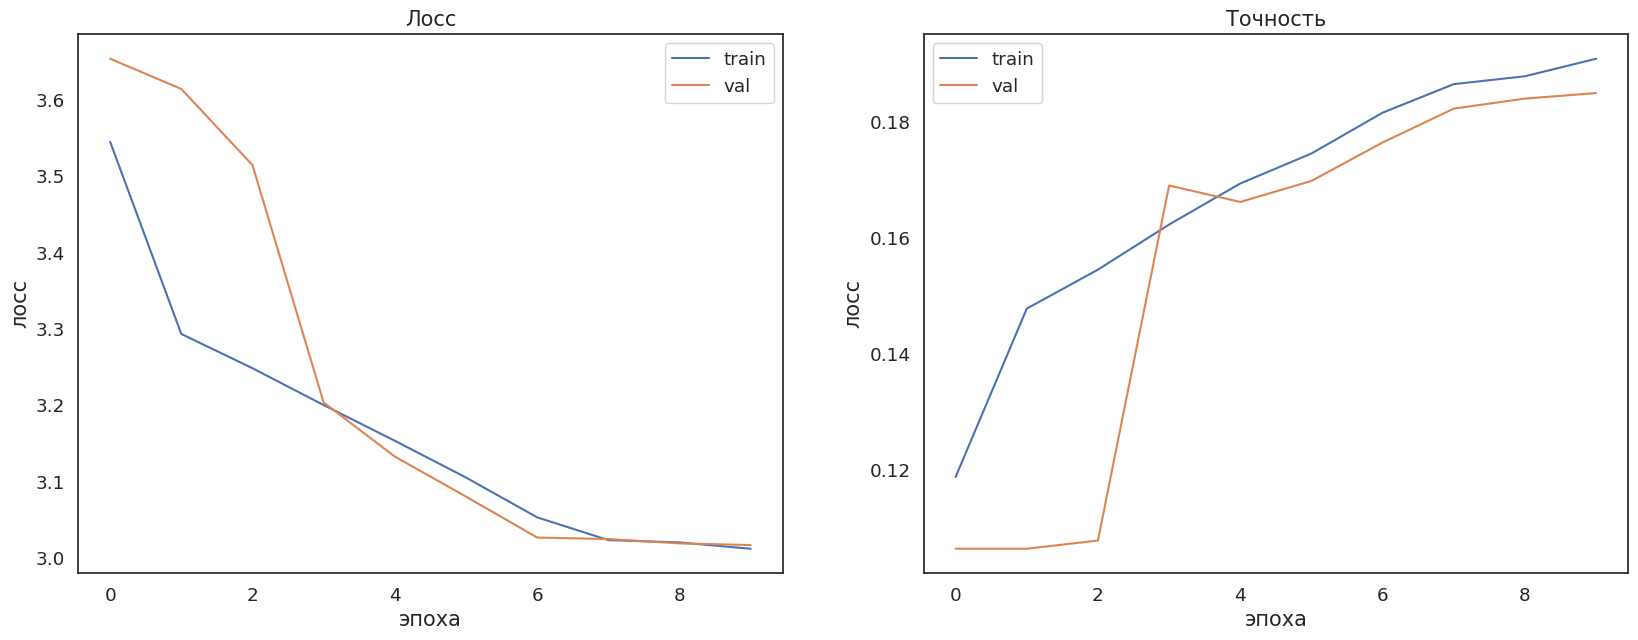

In [ ]:
name = 'MultiStep'
names = ['MultiStep']
criterion = nn.CrossEntropyLoss()
schedulers = []
model = torchvision.models.mobilenet_v3_large(pretrained=False)
model.classifier = torch.nn.Sequential(
                    torch.nn.Linear(in_features=960, out_features=1280, bias=True),
                    torch.nn.Hardswish(),
                    torch.nn.Dropout(p=0.2, inplace=True),
                    torch.nn.Linear(in_features=1280, out_features=42, bias=True)
                    )
model = model.to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
scheduler =  torch.optim.lr_scheduler.MultiStepLR(optimizer=optimizer, milestones=[1,7], gamma=0.1)
schedulers.append(scheduler)

clf_model, history, times, l_rates = train(
      model, criterion, optimizer,
      train_batch_gen, val_batch_gen,
      NUM_EPOCHS, schedulers, names
  )
results[name] = history

In [ ]:
for i in range(10):
    df_results.loc[len(df_results.index)] = ['с нуля','Base', name, times[i], l_rates[i], i, results[name]['loss']['train'][i], results[name]['acc']['train'][i], results[name]['loss']['val'][i], results[name]['acc']['val'][i]]

In [ ]:
df_results

,model,augmentation,sheduler,time,lr,epoch,train_loss,train_accuracy,val_loss,val_accuracy
0,с нуля,Base,None,145.342730,0.01,0,3.560152,0.108645,3.635337,0.106376
1,с нуля,Base,None,135.033336,0.01,1,3.175031,0.135548,3.460162,0.068813
2,с нуля,Base,None,138.215456,0.01,2,2.781609,0.238451,2.931018,0.197759
3,с нуля,Base,None,132.925652,0.01,3,2.416715,0.343489,3.071519,0.269729
4,с нуля,Base,None,136.291000,0.01,4,2.037946,0.450633,2.618468,0.336806
5,с нуля,Base,None,135.750867,0.01,5,1.699053,0.566039,2.245646,0.416351
6,с нуля,Base,None,134.211284,0.01,6,1.414867,0.640977,1.598836,0.585543
7,с нуля,Base,None,134.081580,0.01,7,1.227606,0.681292,1.376758,0.643939
8,с нуля,Base,None,132.940724,0.01,8,1.070580,0.721204,1.339228,0.665562
9,с нуля,Base,None,132.805545,0.01,9,0.926261,0.763545,1.328072,0.661143


In [ ]:
df_results.to_csv('multistep.csv', index=False)

Метрики качества сильно упали. Скорее всего были неудачно инициализированны стартовые веса. Вторая причина в том, что при использовани шедулера шаг обучения пропорционально снижается, и модель просто не успевает набрать то качество, что при обучении без шедулера, а кривая обучения раньше выходит на насыщение.

### Multistep + ReduceLROnPlateau

Epoch 10 of 10 took 132.660s
  training loss (in-iteration): 	2.987479
  validation loss (in-iteration): 	3.007829
  training accuracy: 			19.46 %
  validation accuracy: 			18.64 %


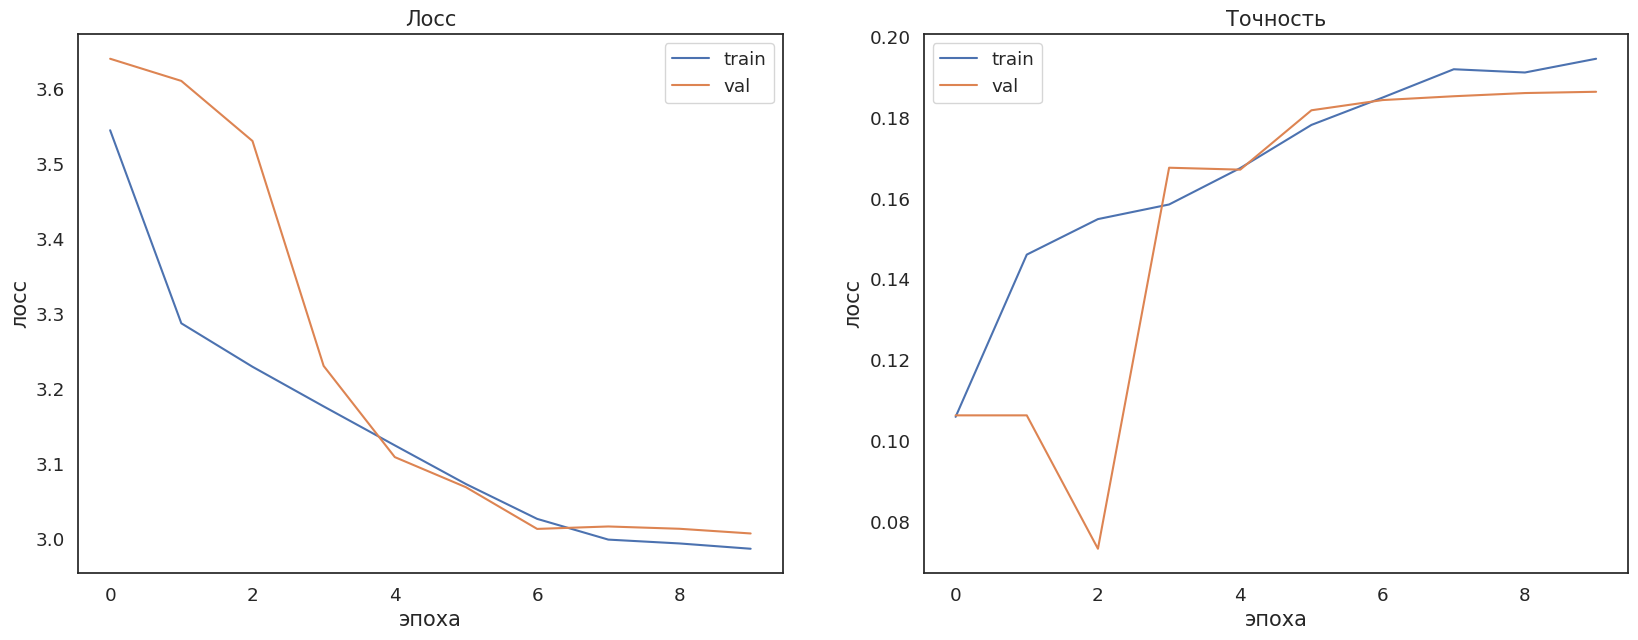

In [ ]:
name = 'Multistep + ReduceLROnPlateau'
names = ['MultiStep', 'ReduceLROnPlateau']
criterion = nn.CrossEntropyLoss()
schedulers = []
model = torchvision.models.mobilenet_v3_large(pretrained=False)
model.classifier = torch.nn.Sequential(
                    torch.nn.Linear(in_features=960, out_features=1280, bias=True),
                    torch.nn.Hardswish(),
                    torch.nn.Dropout(p=0.2, inplace=True),
                    torch.nn.Linear(in_features=1280, out_features=42, bias=True)
                    )
model = model.to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
scheduler1 =  torch.optim.lr_scheduler.MultiStepLR(optimizer=optimizer, milestones=[1,7], gamma=0.1)
schedulers.append(scheduler1)
scheduler2 =   ReduceLROnPlateau(optimizer, 'min',factor=0.95, patience=3,
                                threshold=0.001, min_lr=0.0001, verbose=True)
schedulers.append(scheduler2)
clf_model, history, times, l_rates = train(
      model, criterion, optimizer,
      train_batch_gen, val_batch_gen,
      NUM_EPOCHS, schedulers, names
  )
results[name] = history

In [ ]:
for i in range(10):
    df_results.loc[len(df_results.index)] = ['с нуля','Base', name, times[i], l_rates[i], i, results[name]['loss']['train'][i], results[name]['acc']['train'][i], results[name]['loss']['val'][i], results[name]['acc']['val'][i]]

In [ ]:
df_results

,model,augmentation,sheduler,time,lr,epoch,train_loss,train_accuracy,val_loss,val_accuracy
0,с нуля,Base,None,145.342730,0.01,0,3.560152,0.108645,3.635337,0.106376
1,с нуля,Base,None,135.033336,0.01,1,3.175031,0.135548,3.460162,0.068813
2,с нуля,Base,None,138.215456,0.01,2,2.781609,0.238451,2.931018,0.197759
3,с нуля,Base,None,132.925652,0.01,3,2.416715,0.343489,3.071519,0.269729
4,с нуля,Base,None,136.291000,0.01,4,2.037946,0.450633,2.618468,0.336806
5,с нуля,Base,None,135.750867,0.01,5,1.699053,0.566039,2.245646,0.416351
6,с нуля,Base,None,134.211284,0.01,6,1.414867,0.640977,1.598836,0.585543
7,с нуля,Base,None,134.081580,0.01,7,1.227606,0.681292,1.376758,0.643939
8,с нуля,Base,None,132.940724,0.01,8,1.070580,0.721204,1.339228,0.665562
9,с нуля,Base,None,132.805545,0.01,9,0.926261,0.763545,1.328072,0.661143


In [ ]:
df_results.to_csv('Multistep_ReduceLROnPlateau.csv', index=False)

Качество также низкое, т.к. использование шедулера ReduceLROnPlateau в связке с MultiStepLR приводит к дополнительному снижению шага обучения.

### Mobilenet как Feature Extractor

Epoch 10 of 10 took 113.103s
  training loss (in-iteration): 	1.325966
  validation loss (in-iteration): 	1.278143
  training accuracy: 			68.97 %
  validation accuracy: 			70.39 %


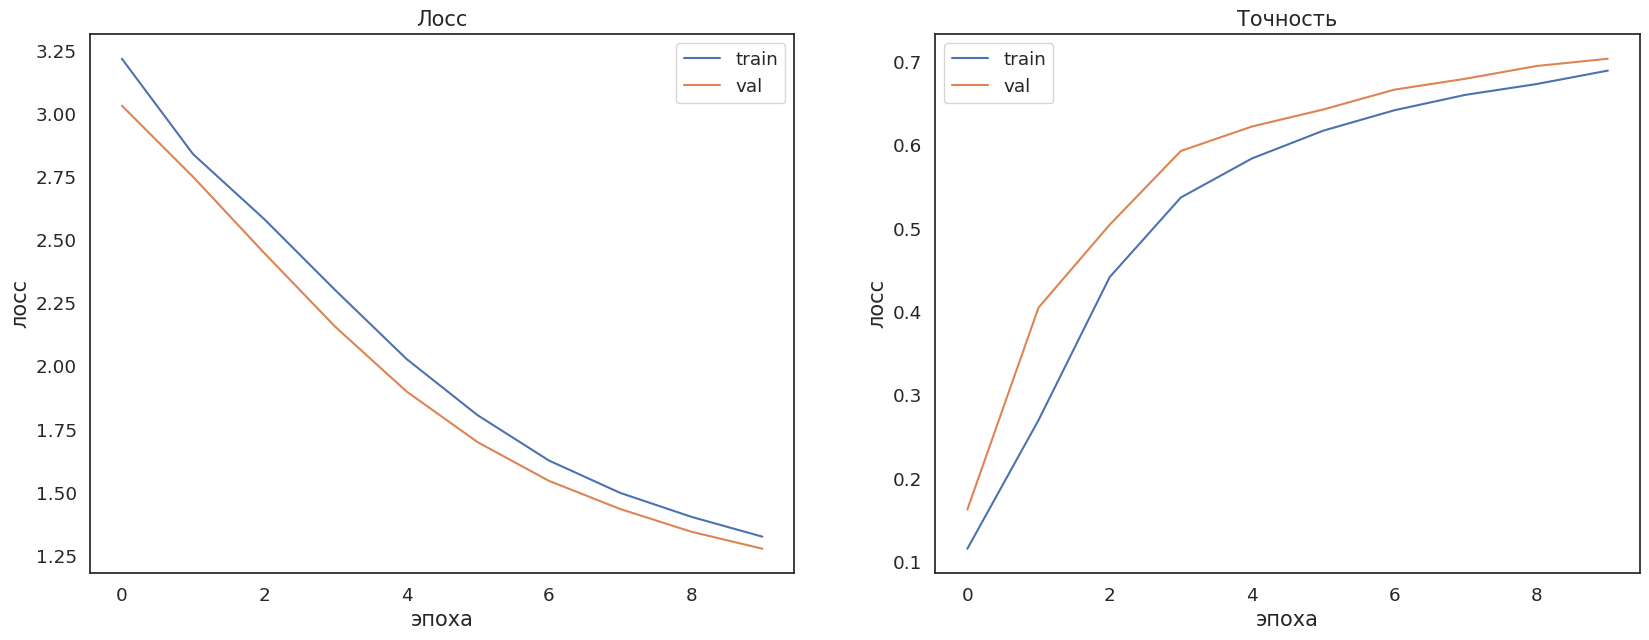

In [21]:
name = 'Feature Extractor'
criterion = nn.CrossEntropyLoss()
model = torchvision.models.mobilenet_v3_large(pretrained=True)

for param in model.parameters():
    param.requires_grad = False

model.classifier = torch.nn.Sequential(
                    torch.nn.Linear(in_features=960, out_features=1280, bias=True),
                    torch.nn.Hardswish(),
                    torch.nn.Dropout(p=0.2, inplace=True),
                    torch.nn.Linear(in_features=1280, out_features=42, bias=True)
                    )

model = model.to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

clf_model, history, times, l_rates = train(
      model, criterion, optimizer,
      train_batch_gen, val_batch_gen,
      NUM_EPOCHS, None
  )

results[name] = history

In [24]:
for i in range(10):
    df_results.loc[len(df_results.index)] = ['feature_extractor','Base', 'None', times[i], l_rates[i], i, results[name]['loss']['train'][i], results[name]['acc']['train'][i], results[name]['loss']['val'][i], results[name]['acc']['val'][i]]

In [25]:
df_results

,model,augmentation,sheduler,time,lr,epoch,train_loss,train_accuracy,val_loss,val_accuracy
0,с нуля,Base,None,145.342730,0.01,0,3.560152,0.108645,3.635337,0.106376
1,с нуля,Base,None,135.033336,0.01,1,3.175031,0.135548,3.460162,0.068813
2,с нуля,Base,None,138.215456,0.01,2,2.781609,0.238451,2.931018,0.197759
3,с нуля,Base,None,132.925652,0.01,3,2.416715,0.343489,3.071519,0.269729
4,с нуля,Base,None,136.291000,0.01,4,2.037946,0.450633,2.618468,0.336806
5,с нуля,Base,None,135.750867,0.01,5,1.699053,0.566039,2.245646,0.416351
6,с нуля,Base,None,134.211284,0.01,6,1.414867,0.640977,1.598836,0.585543
7,с нуля,Base,None,134.081580,0.01,7,1.227606,0.681292,1.376758,0.643939
8,с нуля,Base,None,132.940724,0.01,8,1.070580,0.721204,1.339228,0.665562
9,с нуля,Base,None,132.805545,0.01,9,0.926261,0.763545,1.328072,0.661143


In [26]:
df_results.to_csv('feature_extraction.csv', index=False)

Получен результат на уровне модели со случайными весами. На старте данная модель показала быстрое улучшение метрик, но вскоре вышла на плато. Данный датасет имеет мало общего с данными, на которых была предобучена модель.

### FineTuning

Epoch 10 of 10 took 142.060s
  training loss (in-iteration): 	0.072339
  validation loss (in-iteration): 	0.222736
  training accuracy: 			98.58 %
  validation accuracy: 			94.65 %


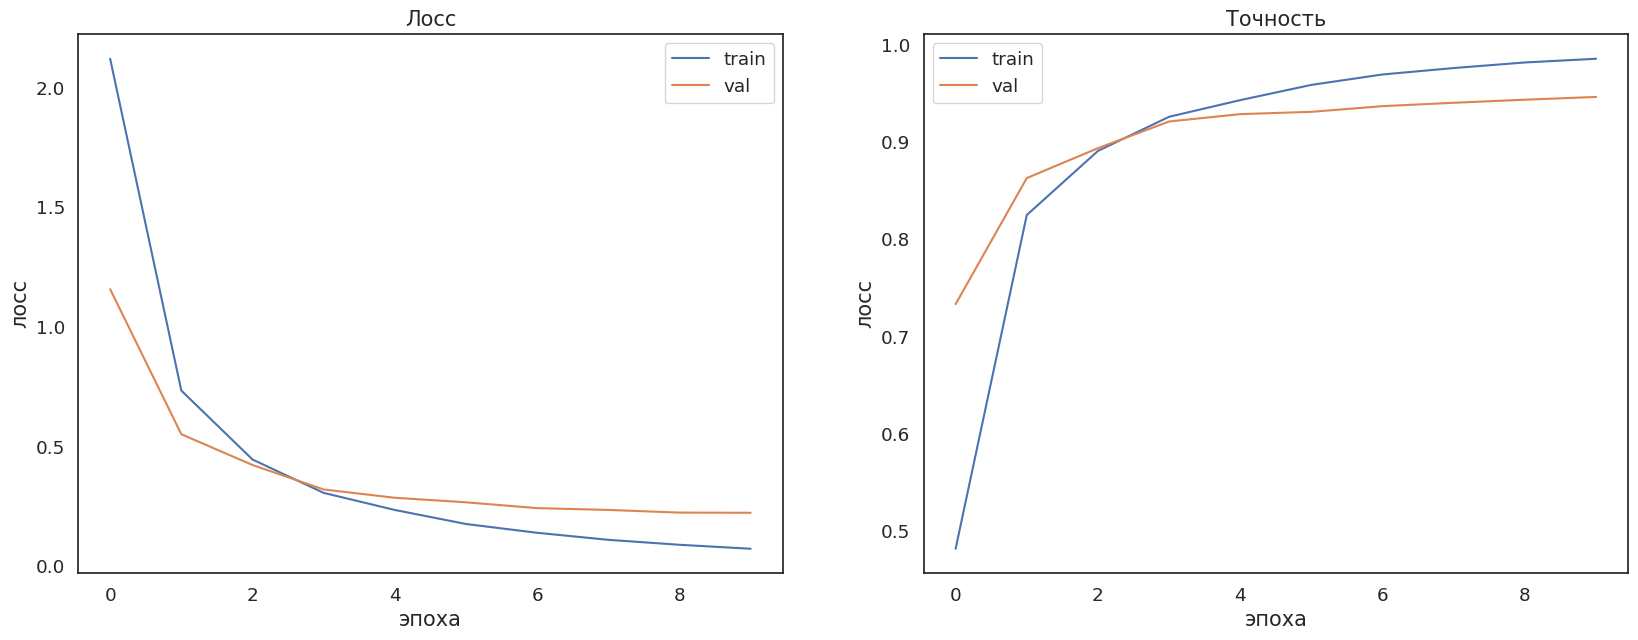

In [27]:
name = 'None'
model = nn.Sequential()
model.add_module('mobilenet',  torchvision.models.mobilenet_v3_large(pretrained=True))

# добавим новые слои для классификации для нашей конкретной задачи
model.add_module('relu_1', nn.ReLU())
model.add_module('fc_1', nn.Linear(1000, 512))
model.add_module('relu_2', nn.ReLU())
model.add_module('fc_2', nn.Linear(512, 42))

model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

clf_model, history, times, l_rates = train(
    model, criterion, optimizer,
    train_batch_gen, val_batch_gen,
    num_epochs=10, schedulers=None, names=None
)
results[name] = history

In [28]:
for i in range(10):
    df_results.loc[len(df_results.index)] = ['fine_tuning','Base', name, times[i], l_rates[i], i, results[name]['loss']['train'][i], results[name]['acc']['train'][i], results[name]['loss']['val'][i], results[name]['acc']['val'][i]]

In [29]:
df_results

,model,augmentation,sheduler,time,lr,epoch,train_loss,train_accuracy,val_loss,val_accuracy
0,с нуля,Base,None,145.342730,0.01,0,3.560152,0.108645,3.635337,0.106376
1,с нуля,Base,None,135.033336,0.01,1,3.175031,0.135548,3.460162,0.068813
2,с нуля,Base,None,138.215456,0.01,2,2.781609,0.238451,2.931018,0.197759
3,с нуля,Base,None,132.925652,0.01,3,2.416715,0.343489,3.071519,0.269729
4,с нуля,Base,None,136.291000,0.01,4,2.037946,0.450633,2.618468,0.336806
5,с нуля,Base,None,135.750867,0.01,5,1.699053,0.566039,2.245646,0.416351
6,с нуля,Base,None,134.211284,0.01,6,1.414867,0.640977,1.598836,0.585543
7,с нуля,Base,None,134.081580,0.01,7,1.227606,0.681292,1.376758,0.643939
8,с нуля,Base,None,132.940724,0.01,8,1.070580,0.721204,1.339228,0.665562
9,с нуля,Base,None,132.805545,0.01,9,0.926261,0.763545,1.328072,0.661143


In [30]:
df_results.to_csv('FineTuning.csv', index=False)

Получен хороший результат. За счет добавления новых слоев моделе легче приспособится под данный датасет.

### Аугментация

In [19]:
train_dataset, val_dataset = prepare_datasets(data_dir, train_augmentations_bad,val_augmentations_bad)

20933 20933
Изображений в train: 14653
Изображений в val: 6280


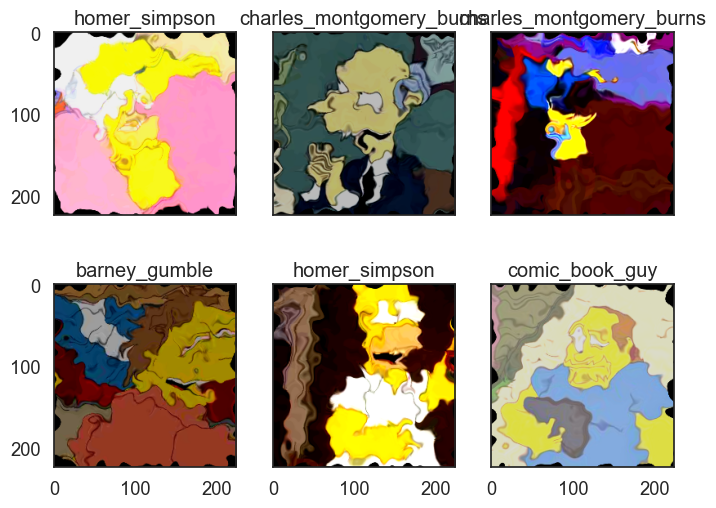

In [20]:
show_images(train_dataset)

In [21]:
train_batch_gen = torch.utils.data.DataLoader(
    train_dataset, batch_size=BATCH_SIZE, shuffle=True
)

val_batch_gen = torch.utils.data.DataLoader(
    val_dataset, batch_size=BATCH_SIZE, shuffle=False
)

Epoch 10 of 10 took 1053.348s
  training loss (in-iteration): 	2.591805
  validation loss (in-iteration): 	2.562013
  training accuracy: 			30.20 %
  validation accuracy: 			26.97 %


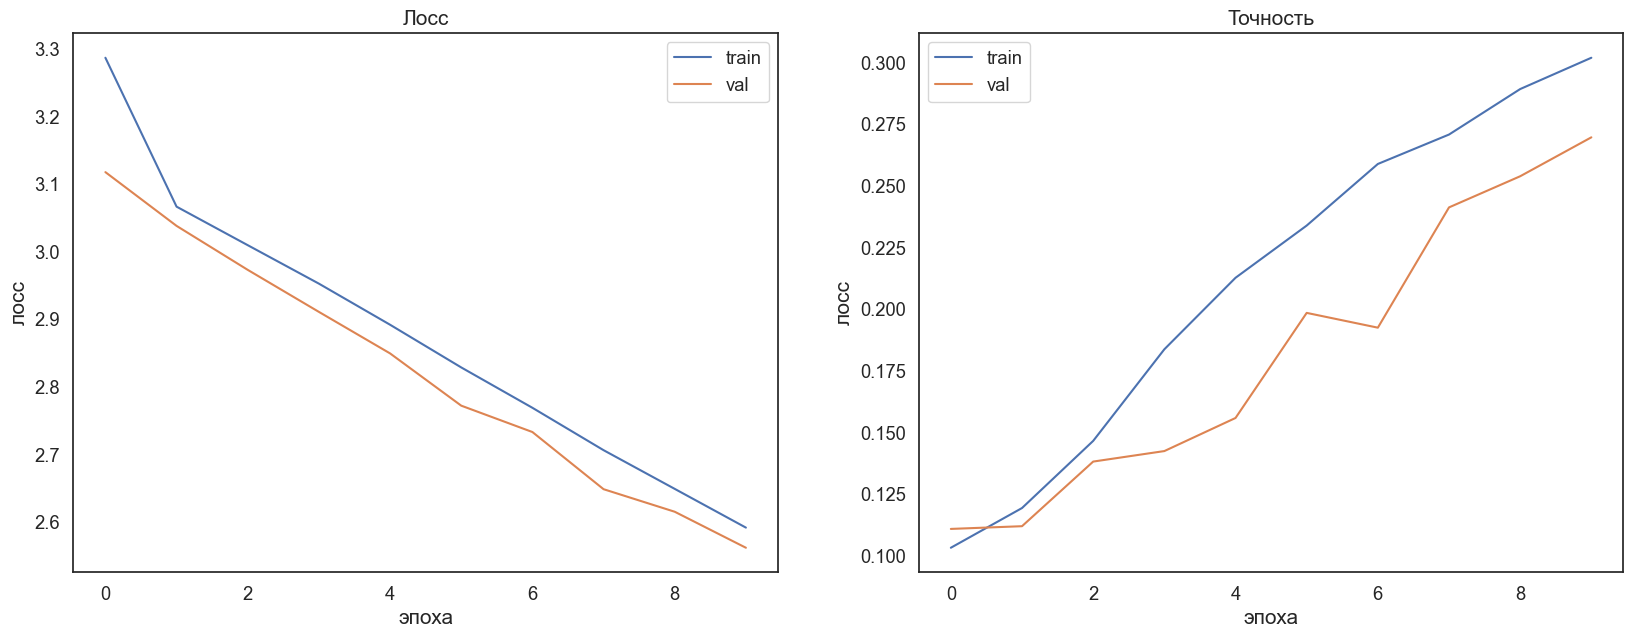

In [22]:
name = 'Augmentation'
criterion = nn.CrossEntropyLoss()
model = torchvision.models.mobilenet_v3_large(pretrained=True)

for param in model.parameters():
    param.requires_grad = False

model.classifier = torch.nn.Sequential(
                    torch.nn.Linear(in_features=960, out_features=1280, bias=True),
                    torch.nn.Hardswish(),
                    torch.nn.Dropout(p=0.2, inplace=True),
                    torch.nn.Linear(in_features=1280, out_features=42, bias=True)
                    )

model = model.to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

clf_model, history, times, l_rates = train(
      model, criterion, optimizer,
      train_batch_gen, val_batch_gen,
      NUM_EPOCHS, None
  )

results[name] = history

In [28]:
for i in range(10):
    df_results.loc[len(df_results.index)] = ['features_extraction','bad', name, times[i], l_rates[i], i, results[name]['loss']['train'][i], results[name]['acc']['train'][i], results[name]['loss']['val'][i], results[name]['acc']['val'][i]]

In [29]:
df_results

,model,augmentation,sheduler,time,lr,epoch,train_loss,train_accuracy,val_loss,val_accuracy
0,с нуля,Base,NaN,145.342730,0.01,0,3.560152,0.108645,3.635337,0.106376
1,с нуля,Base,NaN,135.033336,0.01,1,3.175031,0.135548,3.460162,0.068813
2,с нуля,Base,NaN,138.215456,0.01,2,2.781609,0.238451,2.931018,0.197759
3,с нуля,Base,NaN,132.925652,0.01,3,2.416715,0.343489,3.071519,0.269729
4,с нуля,Base,NaN,136.291000,0.01,4,2.037946,0.450633,2.618468,0.336806
5,с нуля,Base,NaN,135.750867,0.01,5,1.699053,0.566039,2.245646,0.416351
6,с нуля,Base,NaN,134.211284,0.01,6,1.414867,0.640977,1.598836,0.585543
7,с нуля,Base,NaN,134.081580,0.01,7,1.227606,0.681292,1.376758,0.643939
8,с нуля,Base,NaN,132.940724,0.01,8,1.070580,0.721204,1.339228,0.665562
9,с нуля,Base,NaN,132.805545,0.01,9,0.926261,0.763545,1.328072,0.661143


In [30]:
df_results.to_csv('Final.csv', index=False)

При использовании неудачных вариантов аугментации качество модели серьезно ухудшилось.

### Выводы

При использовании transfer learning желательно разморозить часть сверточных слоев, т.к. сложные признаки, ролученные на датасете ImageNet не несут пользы для данного датасета. Несмотря на это, при использовании fine tuning были получены хорошие результаты за счет добавления новых слоев. Так же имеет смысл попробовать использовать оптимизатор с динамическим изменением learning rate, например Adam.